In [1]:
## information about how to use the script
from filmscope.recon_util import (add_sample_entry, get_all_sample_names,
                                  get_ss_volume_from_dataset)
from filmscope.util import play_video
from filmscope.calibration import CalibrationInfoManager
from filmscope.datasets import FSDataset
import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
from filmscope.config import path_to_data

import torch

In [15]:
# view already saved samples 
get_all_sample_names()

['skull_with_tool', 'finger', 'knuckle_video']

In [3]:
# optional: select GPU to be used
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
# necessary information about the dataset 
sample_name = "finger_demo"
# this is the data's location within "path_to_data"
folder = "/finger"
image_filename = folder + '/finger_20240528.nc'
calibration_filename = folder + '/calibration_information'

# blank images can be used to remove illumination artifacts
# set to None if this was not acquired
blank_filename = None # folder + "/blank_image.nc" 
bf = blank_filename 
if bf is not None:
    bf = path_to_data + '/' + bf

In [5]:
# some datasets were calibrated without saving the image shape used to calibrate
# this cell can be used to address that
manager = CalibrationInfoManager(path_to_data + calibration_filename)
if manager.image_shape is None:
    print("adding image shape")
    downsample = 4
    dataset = xr.open_dataset(path_to_data + image_filename)
    image_shape = (len(dataset.x) * downsample, len(dataset.y) * downsample)
    manager.image_shape = image_shape 
    manager.save_all_info()
    print(manager.image_shape)
    dataset = None

In [6]:
# set up a dataset with just the reference image 
ref_camera = CalibrationInfoManager(path_to_data + calibration_filename).reference_camera
downsample = 4
image_numbers = [ref_camera]
dataset = FSDataset(
    path_to_data + image_filename,
    path_to_data + calibration_filename,
    image_numbers,
    downsample,
    (0, 1, 0, 1),
    enforce_divisible=-1,
    frame_number=-1, # set to -1 for single frame images
    blank_filename=bf
)

loading images: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]
/home/clare/anaconda3/envs/filmscope/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115405/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


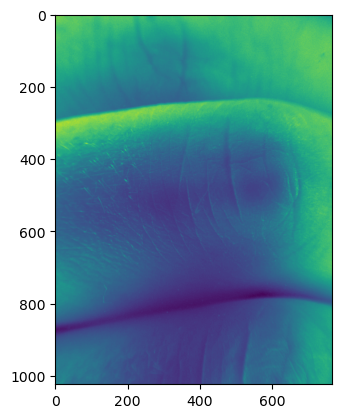

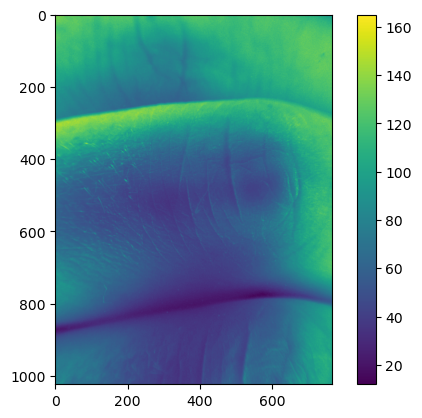

In [8]:
# pick a crop level that shows the desired FOV
crop = (0, 1024, 0, 768) 
full_image = np.squeeze(dataset.reference_image)
crop_image = full_image[crop[0] : crop[1], crop[2] : crop[3]]

plt.imshow(crop_image)

plt.figure()
plt.imshow(full_image)
plt.colorbar()

In [9]:
# determine crop values
shape0 = dataset.images.shape[2]
shape1 = dataset.images.shape[3]

crop_values = (
    crop[0] / shape0,
    crop[1] / shape0,
    crop[2] / shape1,
    crop[3] / shape1,
)
print(crop_values)

(0.0, 1.0, 0.0, 1.0)


In [10]:
dataset = None

# new dataset with the crops
downsample = 4
image_numbers = manager.image_numbers
dataset = FSDataset(
    path_to_data + image_filename,
    path_to_data + calibration_filename,
    image_numbers,
    downsample,
    crop_values,
    enforce_divisible=-1,
    frame_number=-1,
    blank_filename=bf
)

loading images: 100%|██████████| 48/48 [00:05<00:00,  9.34it/s]


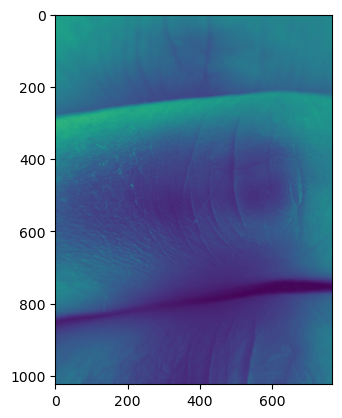

In [11]:
plt.imshow(dataset.images[40].squeeze())

In [19]:
# find depth extents
low_plane = -12
high_plane = 3

num = 30
depths = np.linspace(low_plane, high_plane, num, endpoint=True)
depth_values = torch.from_numpy(depths).to(torch.float32).cuda()

batch_size = 10
volume = get_ss_volume_from_dataset(dataset, batch_size, depth_values, get_squared=False)
volume = volume.squeeze().cpu().numpy()

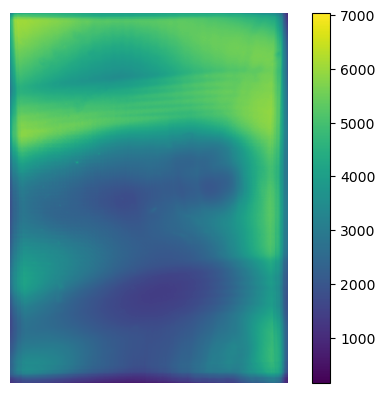

In [20]:
play_video(volume)

Text(0.5, 1.0, '-6.83 mm')

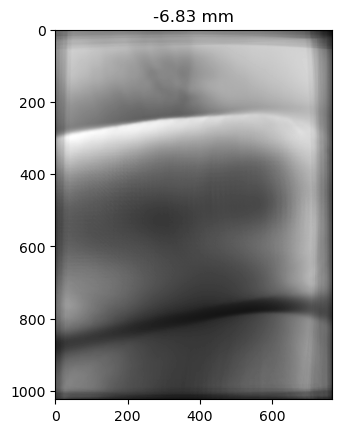

In [21]:
idx = 10
plt.imshow(volume[idx], cmap='gray')
plt.title("{:.2f} mm".format(depths[idx]))

In [22]:
# make the full sample entry
info = {
    "folder": folder,
    "sample_name": sample_name,
    "calibration_filename": calibration_filename,
    "image_filename": image_filename,
    "crop_values": crop_values,
    "depth_range": (low_plane, high_plane),
    "blank_filename": blank_filename,
}

In [23]:
# and save it!
# this cell is commented out for the demo

# add_sample_entry(sample_name, info, overwrite=False)